<a href="https://colab.research.google.com/github/mqc25/Cell_count/blob/master/CellDensityCategory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
Determine Centroid Location

'''


### Imports
%matplotlib inline 
#inline

import os
import sys
import random
import math
import string
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import imageio

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle


In [0]:
def two_panel_extract(fname):
    '''
    MILD formatted

    '''
    print('---->Getting 2Pane image for ', fname)
    imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

    mini_im = []
    rr = []
    cc = []
    extracted_image = []

    #fname = os.path.join(tp_dir,'Mild','Anonymized','12-2','12-3.count.jpg')
    #imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))


    n = np.shape(imdata)
    nr = n[0]
    nc = n[1]

    mid_row = int(nr/2)
    mid_col = int(nc/2) #middle column will be withing white level sep.
    col_slice = imdata[mid_row,:,:]

    plt.figure()
    plt.plot(col_slice[:,:]) #370:410,:])
    plt.title('Column Slice')

    left_pane = imdata[:,0:mid_col,:]
    plt.figure()
    plt.imshow(left_pane)

    #
    #row
    #
    newsize = np.shape(left_pane)
    newrow = newsize[0]
    newcol = newsize[1]

    left_column = left_pane[:,int(newcol/2),:]
    plt.figure()
    plt.plot(left_column)
    plt.title('Row cut for left pane')




    #
    #
    #
    col_slice = left_pane[:,50,:]

    plt.figure()
    plt.plot(col_slice)
    plt.title('column slice')


    a = np.diff(col_slice)
    plt.figure()
    plt.plot(a)
    plt.title('Diff')

    ############################################################################
    #ROW CHECK
    ############################################################################
    upper_bound = 250
    lower_bound = 230
    location = boundary_check(left_column,lower_bound, upper_bound)

    plt.figure()
    plt.plot(location)
    plt.title('location')

    sequence = np.diff(location)
    plt.figure()
    plt.plot(sequence)
    plt.title('sequence')

    #find diff with a gap > 40 pixels
    index = np.argwhere(sequence > 50)
    print('index is ', index)
    start_row = int(index[0] + 2)

    sub_image = left_pane[start_row:,:,:]
    plt.figure()
    plt.imshow(sub_image)
    plt.title('extracted image')

    plt.figure()
    plt.plot(sub_image[:,15,:])
    plt.title('Column cut through extracted image')

    #subtract last rows with border
    #if location values within last 5%, mark those as to be removed
    top5 = int(newrow * 0.95)
    upper_border = []
    for ii in location:
        if (ii >= top5):
            upper_border.append(ii)
    print('upper border row values = ',upper_border)

    top_border_start = np.min(upper_border)


    ####################################################################
    #COLUMN CORRECTION
    #
    ####################################################################
    row_slice = left_pane[mid_row,:,:]

    upper_bound = 250
    lower_bound = 230
    col_location = boundary_check(row_slice,lower_bound, upper_bound)


    #subtract last rows with border
    #if location values within last 5%, mark those as to be removed
    top5 = int(newcol * 0.95)
    upper_border = []
    for ii in col_location:
        if (ii >= top5):
            upper_border.append(ii)
    print('upper border row values = ',upper_border)

    if (np.size(upper_border) == 0):
        return mini_im, rr,cc,extracted_image

    col_stop = np.min(upper_border)



    ######################################################################
    #Format Final Image
    ######################################################################


    #assumption is that left most column is correct
    extracted_image = left_pane[start_row:top_border_start-1,:col_stop,:]

    plt.figure()
    plt.imshow(extracted_image)
    plt.title('Final Image Extraction')




    #
    #Make dummy returns to keep everything in sync
    #
    mini_im = []
    rr = []
    cc = []

    return mini_im, rr,cc,extracted_image

In [0]:
def boundary_check(vector,low_limit, high_limit):
    ############################################################
    # Check for the gray border to correct for any extra windows
    # 
    ############################################################

    location = []
    counter=0
    #upper_bound = 250
    #lower_bound = 230
    for count,ii in enumerate(vector):
        if (   (ii[0] <= high_limit) & (ii[0] >= low_limit)  &
            (ii[1] <= high_limit) & (ii[1] >= low_limit)  &
            (ii[2] <= high_limit) & (ii[2] >= low_limit) ):
            counter = counter + 1 
            location.append(count) #ii)
    return location

In [0]:
def get_middle_gui(imdata):
    print('--Looking for black circle marker in GUI image--')

    #fname = os.path.join(tp_dir,'Severe','Anonymized','14-6','14-6-23.count.jpg')
    #imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

    nxy = np.shape(imdata)
    nr = nxy[0]
    nc = nxy[1]


    #find a black square to find middle of image

    border_skip = 10
    dlength = 3 #6x6  square size. Looking for that circle in middle half of GUI

    valid_row = []
    valid_col = []
    for ii in range(border_skip,nr-border_skip):
        for jj in range(border_skip,nc-border_skip):
            
            square = get_square(imdata, ii, jj,dlength)
            maxval = np.max(square)
            if (maxval <=8):
                valid_row.append(ii)
                valid_col.append(jj)

    gui_middle_row = np.median(valid_row) 
    gui_middle_col = np.median(valid_col) + 20
    print('start GUI middle row, col = ',gui_middle_row, gui_middle_col)

    return gui_middle_row, gui_middle_col

In [0]:
def get_mini_image_2nd_half(fname,im):
    print('---->Getting Mini image for ', fname)
    imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

    nsize = np.shape(imdata)
    nr = nsize[0]
    nc = nsize[1]

    plt.figure()
    plt.imshow(imdata)



    background_2nd = 160 #uniform channel values for RGB

    middle_row = int(nr/2)
    middle_col = int(nc/2)
    quarter_row = int(middle_row/2)
    quarter_col = int(middle_col/2)

    plt.figure()
    plt.imshow(imdata[0:,0:int(nc/2)])
    plt.title('half column')
    plt.plot([quarter_col,quarter_col],[0,200],'g-', lw=2)


    trim_data = imdata[:, 0:middle_col, :]

    row_sample = trim_data[:,quarter_col,:]
    plt.figure()
    plt.plot(row_sample)
    plt.title('Cut through first pass row')


    #
    # Check for the gray border to correct for any extra windows
    #
    box_count = 0
    location = []
    counter=0
    for count,ii in enumerate(row_sample[:-10,:]):
        if (   (ii[0] < 245) & (ii[0] > 235)  &
            (ii[1] < 245) & (ii[1] > 235)  &
            (ii[2] < 245) & (ii[2] > 235) ):
            counter = counter + 1 
            location.append(count) #ii)
        if ((np.median(row_sample[count:count+10,:]) >= 235) &
            (np.median(row_sample[count:count+10,:]) <= 245)):
            #print('found a row box of ten 240s at ', count)
            location.append(count)

    if (np.size(location) > 2):
        new_start_row = location[2] #this should be a start of the border
        print('shape of location is ', np.shape(location))
        print('new_start_row is, middle_col ',new_start_row, middle_col)
        trim_data = imdata[new_start_row:, 0:middle_col, :]
        row_sample = trim_data[:,quarter_col,:]
        
    #set upper and lower row boundaries
    gui_vals = np.argwhere((row_sample[:,1] <= 150) & 
                                (row_sample[:,0] <= 150) & (row_sample[:,2] <= 150))  
    print('starting row for data ',gui_vals[0] + new_start_row) 
    for row_match in gui_vals:
        if (row_match[0] > 50):
            #this should skip most name plates and background windows
            low_row = row_match[0] + new_start_row
            print('new low row found to be ', low_row)
            break

    #low_row = gui_vals[0][0]
    high_row = gui_vals[-1][0]
    print('high row value is ', high_row)



    #correct for smeared pixels
    box_size = 5
    #correcting for bright spots in slide in x direction
    for color_trial in range(0,2):
        location = []
        if (color_trial == 0):
            #gray padding
            color_low = 155
            color_high = 165
        else:
            #GUI window border color
            color_low = 232
            color_high = 245

        for count,ii in enumerate(row_sample[low_row:,:]):

            pixel_location = count + low_row
            temp_array = row_sample[pixel_location:pixel_location + box_size]
            if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

                #print('found a box of ten row counts at ', 
                #    count, ii,np.mean(row_sample[pixel_location:pixel_location+ box_size,:]))
                #print(row_sample[pixel_location,:])
                location.append(count)
                
        if (np.size(location) > 2):
            new_start_row = location[1] + low_row#this should be a start of the border
            print('new low,high crow is ', low_row,new_start_row)
            high_row = new_start_row #+ low_col
            break
        else:
            if (color_trial == 0):
                print('!!!!! Did not find Gray Mapped right edge border')
                continue
            else:
                print('!!!!! Did not find Outer GUI righ edge border!!!!!!!!!')
                break


    plt.figure()
    plt.imshow(trim_data[low_row:high_row,:,:])
    plt.colorbar()
    plt.title('Row Settings Finalized')



    ############################################################################
    #set east and west boundaries
    ############################################################################
    xtrim_data = trim_data[middle_row,:, :]

    col_sample = xtrim_data #[:,quarter_col,:]
    plt.figure()
    plt.plot(col_sample)
    plt.title('column sample line')


    gui_vals = np.argwhere((col_sample[:,1] <= 120) & 
                                (col_sample[:,0] <= 120) & (col_sample[:,2] <= 120))

    for col_match in gui_vals:
        if (col_match[0] > 20):
            #this should skip most name plates and background windows
            low_col = col_match[0]
            print('new low col found to be ', low_col)
            break

    print('starting pixel column is ',low_col) #gui_vals[0]) 
    #low_col = gui_vals[0][0]

    #get the remaining image length

    plt.figure()
    plt.plot(col_sample[low_col:,:])
    plt.title('col sample from first edge on')


    gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                                (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
    high_col = gui_vals[0][0] + low_col

    #correcting for bright spots in slide in x direction

    xtrim_data = trim_data[middle_row,:, :]

    col_sample = xtrim_data #[:,quarter_col,:]
    plt.figure()
    plt.plot(col_sample)
    plt.title('column sample line')

    '''
    data_val = 140
    gui_vals = np.argwhere((col_sample[:,1] <= data_val) & 
                                (col_sample[:,0] <= data_val) & (col_sample[:,2] <= data_val))


    print('in 2nd image, first edge pixel for file  ',fname, gui_vals[0][0]) 
    low_col = gui_vals[0][0]
    '''


    #get the remaining image length

    plt.figure()
    plt.plot(col_sample[low_col:,:])
    plt.title('col sample from first edge on')


    gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                                (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
    high_col = gui_vals[0][0] + low_col

    box_size = 10
    #correcting for bright spots in slide in x direction
    for color_trial in range(0,2):
        location = []
        if (color_trial == 0):
            #gray padding
            color_low = 155
            color_high = 165
        else:
            #GUI window border color
            color_low = 232
            color_high = 245

        for count,ii in enumerate(col_sample[low_col:,:]):

            pixel_location = count + low_col
            temp_array = col_sample[pixel_location:pixel_location + box_size]
            if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

                #print('found a box of ten column counts at ', 
                #    count, ii,np.mean(col_sample[pixel_location:pixel_location+ box_size,:]))
                #print(col_sample[pixel_location,:])
                location.append(count)
                
        if (np.size(location) > 2):
            new_start_col = location[1] + low_col#this should be a start of the border
            print('new low,high col is ', low_col,new_start_col)
            high_col = new_start_col #+ low_col
            break
        else:
            if (color_trial == 0):
                print('!!!!! Did not find Gray Mapped right edge border')
                continue
            else:
                print('!!!!! Did not find Outer GUI right edge border!!!!!!!!!')
                break


    print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
    extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
    plt.figure()
    plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
    plt.colorbar()
    tname = 'Column trim for ' + fname
    plt.title(tname)


    print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
    extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
    plt.figure()
    plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
    plt.colorbar()
    plt.title('Column trim')


    
    return extracted_2nd_image

In [0]:
def get_mini_image(fname):

    newdata = [] #dummy placeholder for valid and error data
    rr=[]
    cc=[]
    extracted_2nd_image = []

    print('Getting mini image from ', fname)

    im = imageio.imread(fname)

    image_size = np.shape(im)
    print('subset image size is ',image_size[0],image_size[1])

    #There are some images that don't follow the normal screen capture format
    # They must be handled outside of this function. Mark them for later use?
    if (image_size[1] < 600):
        print('Count image size is too small. Skipping. Cols = ',image_size[1])
        return newdata,rr,cc,extracted_2nd_image

    #
    #Get column line to find the proper y point to start at
    # -use 86% of x to find column to plot
    pcol = int(image_size[1] * 0.86)
    test_col = np.asarray(im[:,pcol,0])

#    plt.figure()
#    plt.plot(im[:,pcol,:])
#    plt.title('Alignment column')

    #skip the highest 10% of the plot, since that is likely image noise.
    mval = np.median(test_col)
    print('median value is ', mval)
    noise_area = image_size[0] * 0.1
    total_row_length = int(image_size[0] - noise_area)
    even_line = np.median(test_col[total_row_length-50:total_row_length])
    spikes = np.argwhere(test_col[0:total_row_length] >= 245)
    if (np.size(spikes)==0):
        #failure in spike detection, likely due to image with eye photo instead
        #of normal format
        print('Spike Failure! Check Image format for ',fname)
        return newdata,rr,cc,extracted_2nd_image
    print('start row point should be ', spikes[-1])



    #the count images seem to all share the same sizes. This default should work
    start_row = spikes[-1][0]
    #
    #starting column can be inferred from the GUI placed sphere
    #
    half_row, half_col = get_middle_gui(im)
    if (np.isnan(half_row) or np.isnan(half_col)):
        print('\t\t\t!!!!!!found a nan in ', fname)
        return newdata,rr,cc,extracted_2nd_image

    print('half row, col = ',half_row, half_col)
    start_col = int(half_col)
    ###start_col = int(image_size[1] * 0.478)
    print('start col point should be ', start_col)
    small_image = im[start_row:,start_col:,:]

    #
    # Alternative: look for high G channel point
    # - find value > 170
    #Fromthis point, the next white area is the background, so move left and 
    #right until you find background. That should be the image limits
    temp_data=np.asarray(small_image[:,:,:]) #keep G channel

    plt.figure()
    plt.imshow(temp_data)
    plt.colorbar()
    tname = 'temp_data ' + fname
    plt.title(tname)

    #
    #Look for typical green color to find bounding box points
    #

    green_vals = np.argwhere((temp_data[:,:,1] >= 170) & (temp_data[:,:,1] <=190) &
                             (temp_data[:,:,0] < 120) & (temp_data[:,:,2] < 120))   
    if (np.size(green_vals) ==0):
        print('Failure in finding green bounding box. aborting')
        return newdata,rr,cc,extracted_2nd_image


    print('Green Vals[0] ',green_vals[0])
    print('green test ',green_vals[0][0])
    #get a cut through the row to see the rise and fall of background space
    gcol = green_vals[0][1]
    xcut = temp_data[green_vals[0][0],:,0]

    plt.figure()
    plt.plot(xcut)
    plt.plot([gcol,gcol], [0,50], 'g-', lw=2)
    tname = 'cut through green point for ' + fname
    plt.title(tname)

    if (gcol < 12):
        #sub image frame was likely shifted over during capture.  Normal rules
        #won't apply to this one and it should be skipped, for now
        newdata = 0
        print('gcol < 12. Aborting sample')
        return newdata, rr,cc,extracted_2nd_image


    tmp_size = np.shape(temp_data)
    start_point = 0 #default setup
    print('begin values: ',xcut[0:gcol])
    for count, ii in enumerate(xcut[0:gcol][::-1]):
        if (ii >= 200):
            start_point = ii
            break
    if (start_point == 0): #reverse loop to find edge of image failed
        print('failed to find start of subimage')
        return newdata,rr,cc,extracted_2nd_image


    print('start point was found to be ', start_point,count,tmp_size)
    #new edge point of image should be gcol - count # of pixels
    #edited start point for beginning column of sub image
    edited_start_col = gcol - count


    #blanket cut of edges to remove any extra artifacts
    intermediate = np.shape(small_image)
    ir = int(intermediate[0] * 0.1) #removing 10% of subimage
    ic = int(intermediate[1] *.20)
    print('start row, col ', start_row, start_col)
    print('intermediate', intermediate)
    print('ir, ic ', ir, ic)
    small_image = small_image[0:intermediate[0]-ir, 0:intermediate[1]-ic,:]


    #small_image = im[350:,450:,:]
    small_size=np.shape(small_image)
    midrow = int(small_size[0]/2)
    midcol = int(small_size[1]/2)
    print('midrow, midcol = ', midrow, midcol)
    back_color = small_image[midrow,midcol,:] #background color from a sample point



    plt.figure()
    plt.imshow(small_image)
    tname = fname + ' raw small image' + ' ' + str(spikes[-1])
    plt.title(tname)


    data=np.asarray(small_image)
    vals = np.argwhere(data < 60)
    #get first xy and then last, doesn't matter which channel

    #
    #Correct for shifted desktop windows
    #
    for shift in vals:
        if shift[0] < 120:
            shifted_row = shift[0]
            shifted_col = shift[1]
    print('shifted corner is (r,c)',shifted_row, shifted_col)
    small_row = vals[0][0]
    big_row = shifted_row
    small_col = vals[0][1]
    big_col = shifted_col



    first_corner = green_vals[0]
    last_corner = green_vals[-1]

    rr=[]
    cc=[]
    #first_corner = vals[0]
    #last_corner = vals[-1]
    rr.append(first_corner[0])
    #use new start of image area
    cc.append(edited_start_col) #use first green - wall edge length
    rr.append(last_corner[0])
    cc.append(last_corner[1])




    #newdata = small_image[rr[0]:rr[1],cc[0]:cc[1],:]
    ##newdata = small_image[small_row:big_row, small_col:big_col,:]
    newdata = small_image[small_row:big_row, edited_start_col:big_col,:]
    newshape = np.shape(newdata)
    newr = newshape[0]
    newc = newshape[1]



    print('vals shape is ',np.shape(vals))
    print('vals 0 is ',vals[0])
    print('vals end is ', vals[-1])
    print('rr=',rr)
    print('cc=',cc)
    print('newdata is r x c ',newr,newc)
    plt.figure()
    plt.imshow(newdata)
    plt.colorbar()
    plt.title('Extracted sub image')

    #
    # If we got this far, check for the larger image embedded in the screen cap
    #
    #print('looking for larger image in 2 image capture')
    extracted_2nd_image = get_mini_image_2nd_half(fname,im)

    print('returning SubImage ', fname)
    return newdata, rr,cc,extracted_2nd_image

In [0]:
def read_csv_data(full_filename,header=1):
#read in csv data and store in a dictionary

    csv_data=[]

    with open(full_filename) as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        if (header == 1):
            next(csv_reader, None)  # skip the header
        for row in csv_reader:
            #if line_count == 0:
            csv_data.append(np.array(row,dtype=float))
    return csv_data

In [0]:
def get_cross(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol

    #print(lowrow,highrow,lowcol,highcol)
    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]

    return row_data,col_data


In [0]:
def get_square(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nsize = np.shape(data_in)
    nrow = nsize[0]
    ncol = nsize[1]

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow -1
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol -1

    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]


    submatrix = data_in[lowrow:highrow,lowcol:highcol]
    return submatrix

In [0]:
def get_centers(input_data,folder_name, number,descriptor):

    box_width = 5 #pixels
    min_threshold = 0.25

    data = np.asmatrix(input_data)
    nr,nc = np.shape(data)
    
    #data = np.asmatrix(csv_data['y_true_120'])
    peak_counter = 0
    peak_points = {}
    for row in range(0,nr):
        peak_points[row]=[]
        for col in range(0,nc):
            if (row >= 0) and (col >=0):
                subm = get_square(data,row,col, box_width) #box around point
                if (data[row,col] >= np.matrix.max(subm)):
                    #remove any points hovering around background values
                    if (data[row,col] > ( (np.matrix.max(data)) * min_threshold)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    #print(data[row,col], np.max(subm))
                    continue

    plt.imshow(data)
    plt.colorbar()
    for ii in peak_points.keys():
        for jj in peak_points[ii]:
            x=jj
            y=ii
            if (ii == 0):
                mark = 'r.' #use to test special points, if needed
            else:
                mark = 'r.'
            plt.plot(x,y,mark)
    tname = descriptor + '_' + folder_name + '_' + str(keynum) + '_cell count = ' + str(peak_counter) #fname + '_' + 'CellCount= ' + str(peak_counter)
    plt.title(tname)
    plt.show()

    return peak_points

In [9]:
'''
Data directories
'''

use_google_colab = 1 #toggle COLAB setup 
image_type = 0 #0=BCD3, 1 = Raw Density Res. Lab, 2 = Aggregate IMG list
if (use_google_colab == 1):
    ############################################################################
    # Read Data from google drive
    ############################################################################
    from google.colab import drive #for loading gdrive data
    drive.mount('/content/gdrive')

    ###                     MAIN DIRECTORY NAMES
    gdir = '/content/gdrive/My Drive/'
    main_directory = gdir


    if (image_type == 0):
        #main directory for test_prediction_data set
        tp_dir = os.path.join(gdir,'BE224B_2020','Central BCD4')
        mini_pickle = os.path.join(gdir,'BE224B_2020','mini_images.pck')
        extracted_pickle = os.path.join(gdir,'BE224B_2020','extracted_images.pck')
        row_locations = os.path.join(gdir,'BE224B_2020','row_col.csv')
    elif(image_type == 1):
        #sample data set
        image_dir = os.path.join(gdir,'BE224B_2020','Density Research Lab 18 samples')

    elif(image_type == 2):
        image_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','imgs')
        csv_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','xy')
        #truth_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','ground_truth')
        #prediction_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','prediction')
    else:
        print('Incorrect Image Type selected')
        sys.exit()

else:
    ############################################################################
    # Read Data from local drive
    ############################################################################
    print('INSERT LOCAL DRIVE INFO')
    sys.exit()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
'''
Get data folders
'''
if (image_type == 0):
    severity_list = os.listdir(tp_dir)

    patient_folder={}
    for sname in severity_list:
        full_path = os.path.join(tp_dir,sname)
        subfolder = os.listdir(full_path)
        print(subfolder)
        patient_folder[sname]=[]
        for ii in subfolder:
            patient_folder[sname].append(ii)
elif(image_type == 1):
    subfolder_list = os.listdir(image_dir)    
else:
    print('default case')
    subfolder_list = os.listdir(image_dir)


['74-os-1', 'Anonymized', '65-od-1', '50-os-54', '12-od-0', '65-od-2', '74-os-2', '50-os-53', '12-od-1', '12-od-2']
['39-od-13', '14-od-6', '87-od-3', 'Anonymized', '87-os-38', '87-os-37', '87-od-2', '14-od-5', '39-od-12']
['4-od-18', '76-od-7', 'Anonymized', '76-od-8', '4-os-1', '50-od-9']
['N1-od-2', 'N2-od-0', 'N3-od-2', 'Anonymized', 'N1-os-46', 'N3-od-1', 'N1-od-1', 'N2-od-6', 'N1-os-47']


In [0]:
'''
Load the data by severity folders or aggregate folders
'''

if (image_type == 0):

    #BCD2 image set,just use the anon folder data
    im={}
    mini_im={} #subset images from counter image file
    extracted_2nd_image ={} #larger subset image from counter file
    rr ={}
    cc ={}

    full_patient_list ={}
    for sname in severity_list:
        folders = patient_folder[sname]
        full_patient_list[sname] ={}

        #
        # We are concerned with ANON folders for the annotation
        #
        for folder_name in folders:
            if 'ANON' in folder_name.upper():
                full_patient_list[sname][folder_name] = os.path.join(tp_dir,sname,folder_name)

    #
    # Get file listing
    #
    patient_files ={} #hold the anon images
    case_files = {} #hold files for each case folder
    for sname in full_patient_list.keys(): #severity folders
        patient_files[sname]= []
        case_files[sname] ={}

        #if 'ANON' in sname.upper():
            #get files only from anonymous folders
        for sub_dir in full_patient_list[sname]:
            if 'ANON' in sub_dir.upper():

                case_files[sname][sub_dir] ={} #just using Anonymous folder for now
                patient_dir = os.path.join(tp_dir,sname,sub_dir)
                case_dir = os.listdir(patient_dir)
                patient_files[sname].append(case_dir)


                for case_name in case_dir:
                    case_files[sname][sub_dir][case_name] = []
                    full_path = os.path.join(tp_dir,sname,sub_dir, case_name)
                    temp_list = os.listdir(full_path)
                    for filename in temp_list: #get all files within pt folder  
                        case_files[sname][sub_dir][case_name].append(filename)
            else: #series of images
                continue

    for sname in case_files.keys():
        im[sname] = {}
        mini_im[sname] = {}
        extracted_2nd_image[sname] = {}
        rr[sname]={}
        cc[sname] ={}

        #im[sname]['ANON'] = {}
        for case_name in case_files[sname].keys():
            im[sname][case_name] = {}
            mini_im[sname][case_name] = {}
            extracted_2nd_image[sname][case_name] = {}
            rr[sname][case_name] = {}
            cc[sname][case_name] = {}

            print(case_files[sname].keys())
            for pt_dir in case_files[sname][case_name]:
                
                im[sname][case_name][pt_dir] = {}
                mini_im[sname][case_name][pt_dir] = {}
                extracted_2nd_image[sname][case_name][pt_dir] = {}
                rr[sname][case_name][pt_dir] = {}
                cc[sname][case_name][pt_dir] = {}

                print('patient directory is ', pt_dir)
                image_files = os.listdir(os.path.join(tp_dir,sname,case_name,pt_dir))
                print('\timage_files found= ',image_files)

                for filename in image_files:
                    #Read full image into dictionaries
                    if ('COUNT' not in filename.upper()):
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        im[sname][case_name][pt_dir][filename] = imageio.imread(full_file)

                    else: #the annotated file would be here
                        print('!!!!! FOUND COUNT FILE')
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        if(sname.upper() == 'MILD'):
                            #MILD has a different layout. Separate that stream
                            
                            mini_im[sname][case_name][pt_dir][filename], \
                            rr[sname][case_name][pt_dir][filename], \
                            cc[sname][case_name][pt_dir][filename],  \
                            extracted_2nd_image[sname][case_name][pt_dir][filename] = two_panel_extract(full_file)
                        else:


                            mini_im[sname][case_name][pt_dir][filename], \
                                rr[sname][case_name][pt_dir][filename], \
                                cc[sname][case_name][pt_dir][filename],  \
                                extracted_2nd_image[sname][case_name][pt_dir][filename] = get_mini_image(full_file)
                            if (np.size(mini_im[sname][case_name][pt_dir][filename]) ==0):
                                print('EMPTY image found: ',full_file)
    #
    #save results
    #





elif(image_type == 1):
    '''
    Load TIFF images into matrix
    '''
    patient_list = os.listdir(image_dir)

    im = {}
    for folder in patient_list:
        
        folder_check = os.path.isdir(os.path.join(image_dir,folder))
        if ( folder_check == False):
            print('skipping non directory entry ', folder)
            continue

        file_list = os.listdir(os.path.join(image_dir,folder))

        im[folder] ={}
        for filename in file_list:
            if ".JPG" in filename.upper():
                imdata = imageio.imread(os.path.join(image_dir,folder,filename))
                root_ext = os.path.splitext(filename) #will return two parts, name and ext
                keyname = root_ext[0] #dump the extension for the key 
                im[folder][keyname]=np.array(imdata)
            else:
                print('skipping ', filename)                

        #root_ext = os.path.splitext(fname) #will return two parts, name and ext
        #filename=root_ext[0]

else:
    #use aggregated folder, which has all images in one folder
    patient_folder = image_dir
    small_image_list =[]
    file_list = os.listdir(image_dir)

    im={}

    for filename in file_list:
        if "dots" not in filename:
            #print('found dots',root_ext[0])
            small_image_list.append(filename)

            imdata = imageio.imread(os.path.join(image_dir,filename))
            im[filename] = np.array(imdata)
        else:
            continue
        


#
# different datasets will have slightly different structure ordering
#
if (image_type == 1):
    for folder in im.keys():
        for counter,image_key in enumerate(im[folder].keys()):
            if (counter == 0):
                print(np.shape(im[folder][image_key]))
            plt.figure()
            plt.imshow(im[folder][image_key])
            plt.colorbar()
elif (image_type == 2):
    for counter,ii in enumerate(im.keys()):
        if (counter == 0):
            print(np.shape(im[ii]))
        plt.figure()
        plt.imshow(im[ii])
        plt.colorbar()
        #get_square(im, row, col,dlength):

    #im = imageio.imread('filename')
    #im = np.array(im)

In [0]:
'''
test version of definition


'''
#sdata = mini_im['Control']['Anonymized']['N3-2']['N3-2-32.count.jpg']

#fname = os.path.join(tp_dir,'Control','Anonymized','N3-2','N3-2-32.count.jpg')
#fname = os.path.join(tp_dir,'Moderate','Anonymized','4-1','4-1-23.count.jpg')
#fname = os.path.join(tp_dir,'Severe','Anonymized','39-13','39-13-22.count.jpg')
#fname = os.path.join(tp_dir,'Control','Anonymized','N1-46','N1-46-17.count.jpg')
fname = os.path.join(tp_dir,'Severe','Anonymized','14-6','14-6-23.count.jpg')

imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

nsize = np.shape(imdata)
nr = nsize[0]
nc = nsize[1]

plt.figure()
plt.imshow(imdata)



background_2nd = 160 #uniform channel values for RGB

middle_row = int(nr/2)
middle_col = int(nc/2)
quarter_row = int(middle_row/2)
quarter_col = int(middle_col/2)

plt.figure()
plt.imshow(imdata[0:,0:int(nc/2)])
plt.title('half column')
plt.plot([quarter_col,quarter_col],[0,200],'g-', lw=2)


trim_data = imdata[:, 0:middle_col, :]

row_sample = trim_data[:,quarter_col,:]
plt.figure()
plt.plot(row_sample)
plt.title('Cut through first pass row')


#
# Check for the gray border to correct for any extra windows
#
box_count = 0
location = []
counter=0
for count,ii in enumerate(row_sample[:-10,:]):
    if (   (ii[0] < 245) & (ii[0] > 235)  &
        (ii[1] < 245) & (ii[1] > 235)  &
        (ii[2] < 245) & (ii[2] > 235) ):
        counter = counter + 1 
        location.append(ii)
    if ((np.median(row_sample[count:count+10,:]) >= 235) &
        (np.median(row_sample[count:count+10,:]) <= 245)):
        #print('found a row box of ten 240s at ', count)
        location.append(count)

if (np.size(location) > 2):
    new_start_row = location[2] #this should be a start of the border
    trim_data = imdata[new_start_row:, 0:middle_col, :]
    row_sample = trim_data[:,quarter_col,:]
    
#set upper and lower row boundaries
gui_vals = np.argwhere((row_sample[:,1] <= 150) & 
                            (row_sample[:,0] <= 150) & (row_sample[:,2] <= 150))  
print('starting row for data ',gui_vals[0] + new_start_row) 
for row_match in gui_vals:
    if (row_match[0] > 50):
        #this should skip most name plates and background windows
        low_row = row_match[0] + new_start_row
        print('new low row found to be ', low_row)
        break

#low_row = gui_vals[0][0]
high_row = gui_vals[-1][0]
print('high row value is ', high_row)



#correct for smeared pixels
box_size = 5
#correcting for bright spots in slide in x direction
for color_trial in range(0,2):
    location = []
    if (color_trial == 0):
        #gray padding
        color_low = 155
        color_high = 165
    else:
        #GUI window border color
        color_low = 232
        color_high = 245

    for count,ii in enumerate(row_sample[low_row:,:]):

        pixel_location = count + low_row
        temp_array = row_sample[pixel_location:pixel_location + box_size]
        if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

            #print('found a box of ten row counts at ', 
            #    count, ii,np.mean(row_sample[pixel_location:pixel_location+ box_size,:]))
            print(row_sample[pixel_location,:])
            location.append(count)
            
    if (np.size(location) > 2):
        new_start_row = location[1] + low_row#this should be a start of the border
        print('new low,high crow is ', low_row,new_start_row)
        high_row = new_start_row #+ low_col
        break
    else:
        if (color_trial == 0):
            print('!!!!! Did not find Gray Mapped right edge border')
            continue
        else:
            print('!!!!! Did not find Outer GUI righ edge border!!!!!!!!!')
            break











plt.figure()
plt.imshow(trim_data[low_row:high_row,:,:])
plt.colorbar()



############################################################################
#set east and west boundaries
############################################################################
xtrim_data = trim_data[middle_row,:, :]

col_sample = xtrim_data #[:,quarter_col,:]
plt.figure()
plt.plot(col_sample)
plt.title('column sample line')


gui_vals = np.argwhere((col_sample[:,1] <= 120) & 
                            (col_sample[:,0] <= 120) & (col_sample[:,2] <= 120))

for col_match in gui_vals:
    if (col_match[0] > 20):
        #this should skip most name plates and background windows
        low_col = col_match[0]
        print('new low col found to be ', low_col)
        break

print('starting pixel column is ',low_col) #gui_vals[0]) 
#low_col = gui_vals[0][0]

#get the remaining image length

plt.figure()
plt.plot(col_sample[low_col:,:])
plt.title('col sample from first edge on')


gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                            (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
high_col = gui_vals[0][0] + low_col

#correcting for bright spots in slide in x direction

xtrim_data = trim_data[middle_row,:, :]

col_sample = xtrim_data #[:,quarter_col,:]
plt.figure()
plt.plot(col_sample)
plt.title('column sample line')

'''
data_val = 140
gui_vals = np.argwhere((col_sample[:,1] <= data_val) & 
                            (col_sample[:,0] <= data_val) & (col_sample[:,2] <= data_val))


print('in 2nd image, first edge pixel for file  ',fname, gui_vals[0][0]) 
low_col = gui_vals[0][0]
'''


#get the remaining image length

plt.figure()
plt.plot(col_sample[low_col:,:])
plt.title('col sample from first edge on')


gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                            (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
high_col = gui_vals[0][0] + low_col

box_size = 10
#correcting for bright spots in slide in x direction
for color_trial in range(0,2):
    location = []
    if (color_trial == 0):
        #gray padding
        color_low = 155
        color_high = 165
    else:
        #GUI window border color
        color_low = 232
        color_high = 245

    for count,ii in enumerate(col_sample[low_col:,:]):

        pixel_location = count + low_col
        temp_array = col_sample[pixel_location:pixel_location + box_size]
        if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

            #print('found a box of ten column counts at ', 
            #    count, ii,np.mean(col_sample[pixel_location:pixel_location+ box_size,:]))
            #print(col_sample[pixel_location,:])
            location.append(count)
            
    if (np.size(location) > 2):
        new_start_col = location[1] + low_col#this should be a start of the border
        print('new low,high col is ', low_col,new_start_col)
        high_col = new_start_col #+ low_col
        break
    else:
        if (color_trial == 0):
            print('!!!!! Did not find Gray Mapped right edge border')
            continue
        else:
            print('!!!!! Did not find Outer GUI righ edge border!!!!!!!!!')
            break


print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
plt.figure()
plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
plt.colorbar()
tname = 'Column trim for ' + fname
plt.title(tname)










print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
plt.figure()
plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
plt.colorbar()
plt.title('Column trim')

#find end of GUI background

#get_mini_image_2nd_half(fname,im)

In [13]:
'''
Bad Image: get empty list
['Severe', 'Anonymized', '14-6', '14-6-23.count.jpg']
['Moderate', 'Anonymized', '50-9', '50-9-18.count.jpg']
Entire 'Mild' folder
Bloated mini image: has extra whitespace
['Severe', 'Anonymized', '87-37', '87-37-count.jpg']
['Moderate', 'Anonymized', '76-8', '76-8-27.count.jpg'] (edited) 

'''
mini_im['Severe']['Anonymized']['14-6']['14-6-23.count.jpg']

Array([[[20, 20, 20],
        [17, 17, 17],
        [24, 24, 24],
        ...,
        [29, 29, 29],
        [26, 26, 26],
        [31, 31, 31]],

       [[21, 21, 21],
        [27, 27, 27],
        [25, 25, 25],
        ...,
        [31, 31, 31],
        [25, 25, 25],
        [31, 31, 31]],

       [[21, 21, 21],
        [24, 24, 24],
        [25, 25, 25],
        ...,
        [31, 31, 31],
        [26, 26, 26],
        [26, 26, 26]],

       ...,

       [[23, 23, 23],
        [25, 25, 25],
        [28, 28, 28],
        ...,
        [23, 23, 23],
        [26, 26, 26],
        [26, 26, 26]],

       [[22, 22, 22],
        [24, 24, 24],
        [30, 30, 30],
        ...,
        [24, 24, 24],
        [27, 27, 27],
        [26, 26, 26]],

       [[30, 30, 30],
        [26, 26, 26],
        [19, 19, 19],
        ...,
        [28, 28, 28],
        [18, 18, 18],
        [32, 32, 32]]], dtype=uint8)

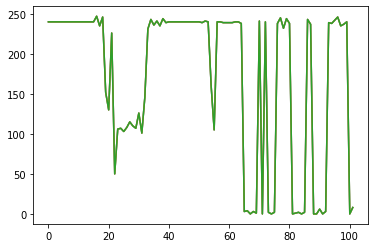

In [14]:
a = col_sample[400:,:]
plt.figure()
plt.plot(a)

(102, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


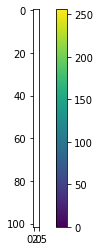

In [15]:
'''
FFT TEST

'''

if (image_type == 1):
    klist = list(im.keys())
    klist[0]
    mlist = list(im[klist[0]].keys())
    print(mlist[0])
    a = im[klist[0]][mlist[0]][:,:,0]
elif (image_type == 2):
    klist = im.keys()
    print(klist)
    a = im[klist[0]]


plt.figure()
#a=im['D1_R1_day_9_Image1.tif'][:,:,2]
#a=im['D1_R4_day_9_Image6.tif'][0][:,:,2]
print(np.shape(a))

f = np.fft.fft2(a)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.imshow(magnitude_spectrum,vmin=0, vmax = 256)
plt.colorbar()

In [0]:
'''
Get Sharpness estimates per channel for a square
'''
from cycler import cycler #change default color cycles for plot

mcolor = ['Reds','Greens','Blues']
# Set the default color cycle
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "g", "b"])

if (image_type == 1): #Density Research Lab Raw images
    test_data = im['D1 R1 day 9']['Image1']

    plt.figure()
    plt.imshow(test_data)
    plt.colorbar()
    plt.title('FULL ORIGINAL IMAGE')

    #plot full channel subset 
    a = test_data[75:125,75:125,:].astype(int)
    plt.figure()
    plt.imshow(a)
    plt.colorbar()
    plt.title('small subset w/ all channels')

    #test line plot
    plt.figure()
    plt.plot(a[17,:,])
    plt.title('slice through row 17 of subset')
    plt.legend(('Chan 0','Chan 1','Chan 2'))



    #custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
    #             cycler(lw=[1, 2, 3, 4]))
    fig = plt.figure()
    ax0=plt.gca()
    ax0 = plt.plot(a[:,7])
    ax0 = plt.title('slice through column 7 of subset')
    ax0 = plt.legend(('Chan 0','Chan 1','Chan 2'))

    



    #plt.figure()
    #plt.plot(a[:,7])
    #plt.title('slice through column of subset')  
    #plt.legend(('Chan 0','Chan 1','Chan 2'))
    #plt.show()

elif(image_type == 2):
    print('Running Image Type 2')
    test_data =im['D1_R1_day_9_Image1.tif']


    for ii in range(0,3):  #alternate color channels

        b=test_data[:,:,ii]

        image_shape = np.shape(b)
        
        

        #get a sample box for testing
        a = get_square(b, 100, 100,25).astype(int) #75,75 to 125,125

        dx = np.diff(a)[1:,:] # remove the first row
        dy = np.diff(a, axis=0)[:,1:] # remove the first column
        dnorm = np.sqrt(dx**2 + dy**2)
        sharpness = np.average(dnorm)


        b=dnorm[0,0]
        type(b)
        float(b)
        isinstance(float(b),float)

        plt.figure()
        plt.imshow(a, cmap=mcolor[ii])
        plt.colorbar()
        stext = 'original ' + str(ii)
        plt.title(stext)


        b=dnorm.astype(float)
        plt.figure()
        plt.imshow(b,cmap=mcolor[ii])
        plt.colorbar()
        stext = mcolor[ii] + ' Sharpness=' + str(sharpness)
        plt.title(stext)






In [17]:
plt.figure()
plt.plot(dx[10,:])

plt.figure()
plt.plot(a[11,:])
plt.title('original slice ')
dd = np.diff(a[11,:])
plt.figure()
plt.plot(dd)

plt.figure()
plt.imshow(a)
plt.colorbar()
plt.title('original box')

plt.figure()
plt.imshow(dx,cmap='Reds')
plt.colorbar()

plt.figure()
plt.imshow(dy)
plt.colorbar()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [75]:
# Store data (serialize)

with open(mini_pickle, 'wb') as handle:
    pickle.dump(mini_im, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(extracted_pickle, 'wb') as handle:
    pickle.dump(extracted_2nd_image, handle, protocol=pickle.HIGHEST_PROTOCOL)

# extracted_2nd_image[sname][case_name][pt_dir][filename]
#write CVS row col

#with open('csvfile.csv','wb') as file:
f = open(row_locations,'w')

header = 'severity' + '\t' + 'Case' + '\t' + 'PatientFolder' + '\t' + 'FileName' + '\t' + 'Top Left,Bot Left R'+ '\t' + 'Top Left, Bot R Col' + '\n'
f.write(header)
for ss in rr.keys():
    for case in rr[ss].keys():
        for pt in rr[ss][case].keys():
            for fn in rr[ss][case][pt].keys():
                rows = rr[ss][case][pt][fn]
                cols = cc[ss][case][pt][fn]
                print(rows,cols)
                text = ss + '\t' + case + '\t' + pt + '\t' + fn + '\t' + str(rows) + '\t' + str(cols) + '\n'

                #f = open('csvfile.csv','w')
                f.write(text) #Give your csv text here.
                ## Python will convert \n to os.linesep
f.close()



[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[54, 70] [5, 46]
[30, 42] [5, 43]
[14, 39] [12, 55]
[25, 50] [6, 25]
[40, 49] [6, 58]
[43, 68] [5, 24]
[24, 53] [4, 37]
[31, 60] [5, 34]
[17, 38] [5, 69]
[48, 75] [6, 39]
[44, 58] [5, 49]
[] []
[44, 58] [5, 49]
[54, 62] [5, 51]
[15, 38] [6, 40]
[51, 73] [5, 54]
[54, 74] [6, 59]
[41, 64] [5, 39]
[60, 77] [6, 53]
[39, 58] [5, 44]
[59, 72] [5, 59]
[38, 57] [5, 39]
[42, 57] [6, 48]
[31, 52] [5, 62]
[43, 60] [5, 56]
[] []
[50, 77] [5, 41]
[48, 67] [5, 61]
[43, 61] [5, 48]
[32, 66] [5, 34]
[] []
[42, 54] [6, 60]
[33, 46] [5, 35]
[35, 46] [6, 35]


In [0]:
'''
Test small image


'''


fname = os.path.join(tp_dir,'Severe','Anonymized','14-6','14-6-23.count.jpg')
imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))
newdata = [] #dummy placeholder for valid and error data
rr=[]
cc=[]
extracted_2nd_image = []

print('Getting mini image from ', fname)

im = imageio.imread(fname)

image_size = np.shape(im)
print('subset image size is ',image_size[0],image_size[1])

#There are some images that don't follow the normal screen capture format
# They must be handled outside of this function. Mark them for later use?
if (image_size[1] < 600):
    print('Count image size is too small. Skipping. Cols = ',image_size[1])
    #return newdata,rr,cc,extracted_2nd_image

#
#Get column line to find the proper y point to start at
# -use 86% of x to find column to plot
pcol = int(image_size[1] * 0.86)
test_col = np.asarray(im[:,pcol,0])

#    plt.figure()
#    plt.plot(im[:,pcol,:])
#    plt.title('Alignment column')

#skip the highest 10% of the plot, since that is likely image noise.
mval = np.median(test_col)
print('median value is ', mval)
noise_area = image_size[0] * 0.1
total_row_length = int(image_size[0] - noise_area)
even_line = np.median(test_col[total_row_length-50:total_row_length])
spikes = np.argwhere(test_col[0:total_row_length] >= 245)
if (np.size(spikes)==0):
    #failure in spike detection, likely due to image with eye photo instead
    #of normal format
    print('Spike Failure! Check Image format for ',fname)
    #return newdata,rr,cc,extracted_2nd_image
print('start row point should be ', spikes[-1])



#the count images seem to all share the same sizes. This default should work
start_row = spikes[-1][0]


###############################################################
#starting column can be inferred from the GUI placed sphere
###############################################################
half_row, half_col = get_middle_gui(im)
if (np.isnan(half_row) or np.isnan(half_col)):
    print('\t\t\t!!!!!!found a nan in ', fname)
    #return newdata,rr,cc,extracted_2nd_image

print('half row, col = ',half_row, half_col)
start_col = int(half_col)




#start_col = int(image_size[1] * 0.478)
print('start col from gui image should be ', start_col)
small_image = im[start_row:,start_col:,:]

#
# Alternative: look for high G channel point
# - find value > 170
#Fromthis point, the next white area is the background, so move left and 
#right until you find background. That should be the image limits
temp_data=np.asarray(small_image[:,:,:]) #keep G channel

plt.figure()
plt.imshow(temp_data)
plt.colorbar()
tname = 'temp_data ' + fname
plt.title(tname)


#green_vals = np.argwhere((temp_data > 170) & (temp_data <190))
green_vals = np.argwhere((temp_data[:,:,1] >= 170) & (temp_data[:,:,1] <=190) &
                            (temp_data[:,:,0] < 120) & (temp_data[:,:,2] < 120))   
if (np.size(green_vals) ==0):
    print('Failure in finding green bounding box. aborting')
    #return newdata,rr,cc,extracted_2nd_image

#plot green points onto image above
for rvals in green_vals:
    plt.plot(rvals[1],rvals[0],'ro')


print('Green Vals[0] ',green_vals[0])
print('green test ',green_vals[0][0])
#get a cut through the row to see the rise and fall of background space
gcol = green_vals[0][1]
xcut = temp_data[green_vals[0][0],:,0]

plt.figure()
plt.plot(xcut)
plt.plot([gcol,gcol], [0,50], 'g-', lw=2)
tname = 'cut through green point for ' + fname
plt.title(tname)

if (gcol < 12):
    #sub image frame was likely shifted over during capture.  Normal rules
    #won't apply to this one and it should be skipped, for now
    newdata = 0
    print('---------gcol < 12. Aborting sample')
    #return newdata, rr,cc,extracted_2nd_image


tmp_size = np.shape(temp_data)
start_point = 0 #default setup
print('begin values: ',xcut[0:gcol])
for count, ii in enumerate(xcut[0:gcol][::-1]):
    if (ii >= 200):
        start_point = ii
        break
if (start_point == 0): #reverse loop to find edge of image failed
    print('failed to find start of subimage')
    #return newdata,rr,cc,extracted_2nd_image


print('start point was found to be ', start_point,count,tmp_size)
#new edge point of image should be gcol - count # of pixels
#edited start point for beginning column of sub image
edited_start_col = gcol - count


#blanket cut of edges to remove any extra artifacts
intermediate = np.shape(small_image)
ir = int(intermediate[0] * 0.1) #removing 10% of subimage
ic = int(intermediate[1] *.20)
print('start row, col ', start_row, start_col)
print('intermediate', intermediate)
print('ir, ic ', ir, ic)
small_image = small_image[0:intermediate[0]-ir, 0:intermediate[1]-ic,:]


#small_image = im[350:,450:,:]
small_size=np.shape(small_image)
midrow = int(small_size[0]/2)
midcol = int(small_size[1]/2)
print('midrow, midcol = ', midrow, midcol)
back_color = small_image[midrow,midcol,:] #background color from a sample point



plt.figure()
plt.imshow(small_image)
tname = fname + ' raw small image' + ' ' + str(spikes[-1])
plt.title(tname)

data=np.asarray(small_image)
vals = np.argwhere(data < 50)
#get first xy and then last, doesn't matter which channel
rr=[]
cc=[]
first_corner = vals[0]

#
#Correct for shifted desktop windows
#
for shift in vals:
    if shift[0] < 120:
        shifted_row = shift[0]
        shifted_col = shift[1]
print('shifted corner is (r,c)',shifted_row, shifted_col)
small_row = vals[0][0]
big_row = shifted_row
small_col = vals[0][1]
big_col = shifted_col

#last_corner = vals[-1]
last_corner = [shifted_row, shifted_col]

rr.append(first_corner[0])
#use new start of image area
cc.append(edited_start_col) #use first green - wall edge length
#cc.append(first_corner[1])
rr.append(last_corner[0])
cc.append(last_corner[1])



'''
small_row = 999
small_col = 999
big_row = 0
big_col = 0
for ii in vals:
    if (ii[0] < small_row):
        small_row = ii[0]
    if (ii[1] < small_col):
        small_col = ii[1]
    if (ii[0] > big_row):
        big_row = ii[0]
    if (ii[1] > big_col):
        big_col = ii[1]

print('smallest val row col is ', small_row, small_col)
print('biggest val row col is ', big_row, big_col)    
'''


#newdata = small_image[rr[0]:rr[1],cc[0]:cc[1],:]
##newdata = small_image[small_row:big_row, small_col:big_col,:]
newdata = small_image[small_row:big_row, edited_start_col:big_col,:]
newshape = np.shape(newdata)
newr = newshape[0]
newc = newshape[1]



print('vals shape is ',np.shape(vals))
print('vals 0 is ',vals[0])
print('vals end is ', vals[-1])
print('rr=',rr)
print('cc=',cc)
print('newdata is r x c ',newr,newc)
plt.figure()
plt.imshow(newdata)
plt.colorbar()
plt.title('Extracted sub image')




In [0]:
print(green_vals[0])
print(green_vals[-1])


In [0]:
'''
Test 2nd image

'''
fname = os.path.join(tp_dir,'Severe','Anonymized','14-6','14-6-23.count.jpg')
imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

nsize = np.shape(imdata)
nr = nsize[0]
nc = nsize[1]

plt.figure()
plt.imshow(imdata)



background_2nd = 160 #uniform channel values for RGB

middle_row = int(nr/2)
middle_col = int(nc/2)
quarter_row = int(middle_row/2)
quarter_col = int(middle_col/2)

plt.figure()
plt.imshow(imdata[0:,0:int(nc/2)])
plt.title('half column')
plt.plot([quarter_col,quarter_col],[0,200],'g-', lw=2)


trim_data = imdata[:, 0:middle_col, :]

row_sample = trim_data[:,quarter_col,:]
plt.figure()
plt.plot(row_sample)
plt.title('Cut through first pass row')


#
# Check for the gray border to correct for any extra windows
#
box_count = 0
location = []
counter=0
for count,ii in enumerate(row_sample[:-10,:]):
    if (   (ii[0] < 245) & (ii[0] > 235)  &
        (ii[1] < 245) & (ii[1] > 235)  &
        (ii[2] < 245) & (ii[2] > 235) ):
        counter = counter + 1 
        location.append(ii)
    if ((np.median(row_sample[count:count+10,:]) >= 235) &
        (np.median(row_sample[count:count+10,:]) <= 245)):
        #print('found a row box of ten 240s at ', count)
        location.append(count)

if (np.size(location) > 2):
    new_start_row = location[2] #this should be a start of the border
    trim_data = imdata[new_start_row:, 0:middle_col, :]
    row_sample = trim_data[:,quarter_col,:]
    
#set upper and lower row boundaries
gui_vals = np.argwhere((row_sample[:,1] <= 150) & 
                            (row_sample[:,0] <= 150) & (row_sample[:,2] <= 150))  
print('starting row for data ',gui_vals[0] + new_start_row) 
for row_match in gui_vals:
    if (row_match[0] > 50):
        #this should skip most name plates and background windows
        low_row = row_match[0] + new_start_row
        print('new low row found to be ', low_row)
        break

#low_row = gui_vals[0][0]
high_row = gui_vals[-1][0]
print('high row value is ', high_row)



#correct for smeared pixels
box_size = 5
#correcting for bright spots in slide in x direction
for color_trial in range(0,2):
    location = []
    if (color_trial == 0):
        #gray padding
        color_low = 155
        color_high = 165
    else:
        #GUI window border color
        color_low = 232
        color_high = 245

    for count,ii in enumerate(row_sample[low_row:,:]):

        pixel_location = count + low_row
        temp_array = row_sample[pixel_location:pixel_location + box_size]
        if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

            #print('found a box of ten row counts at ', 
            #    count, ii,np.mean(row_sample[pixel_location:pixel_location+ box_size,:]))
            #print(row_sample[pixel_location,:])
            location.append(count)
            
    if (np.size(location) > 2):
        new_start_row = location[1] + low_row#this should be a start of the border
        print('new low,high crow is ', low_row,new_start_row)
        high_row = new_start_row #+ low_col
        break
    else:
        if (color_trial == 0):
            print('!!!!! Did not find Gray Mapped right edge border')
            continue
        else:
            print('!!!!! Did not find Outer GUI righ edge border!!!!!!!!!')
            break


plt.figure()
plt.imshow(trim_data[low_row:high_row,:,:])
plt.colorbar()
plt.title('Row Settings Finalized')



############################################################################
#set east and west boundaries
############################################################################
xtrim_data = trim_data[middle_row,:, :]

col_sample = xtrim_data #[:,quarter_col,:]
plt.figure()
plt.plot(col_sample)
plt.title('column sample line')


gui_vals = np.argwhere((col_sample[:,1] <= 120) & 
                            (col_sample[:,0] <= 120) & (col_sample[:,2] <= 120))

for col_match in gui_vals:
    if (col_match[0] > 20):
        #this should skip most name plates and background windows
        low_col = col_match[0]
        print('new low col found to be ', low_col)
        break

print('starting pixel column is ',low_col) #gui_vals[0]) 
#low_col = gui_vals[0][0]

#get the remaining image length

plt.figure()
plt.plot(col_sample[low_col:,:])
plt.title('col sample from first edge on')


gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                            (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
high_col = gui_vals[0][0] + low_col

#correcting for bright spots in slide in x direction

xtrim_data = trim_data[middle_row,:, :]

col_sample = xtrim_data #[:,quarter_col,:]
plt.figure()
plt.plot(col_sample)
plt.title('column sample line')

'''
data_val = 140
gui_vals = np.argwhere((col_sample[:,1] <= data_val) & 
                            (col_sample[:,0] <= data_val) & (col_sample[:,2] <= data_val))


print('in 2nd image, first edge pixel for file  ',fname, gui_vals[0][0]) 
low_col = gui_vals[0][0]
'''


#get the remaining image length

plt.figure()
plt.plot(col_sample[low_col:,:])
plt.title('col sample from first edge on')


gui_vals = np.argwhere((col_sample[low_col:,1] > 150) & 
                            (col_sample[low_col:,0] > 150) & (col_sample[low_col:,2] > 150))  
high_col = gui_vals[0][0] + low_col

box_size = 10
#correcting for bright spots in slide in x direction
for color_trial in range(0,2):
    location = []
    if (color_trial == 0):
        #gray padding
        color_low = 155
        color_high = 165
    else:
        #GUI window border color
        color_low = 232
        color_high = 245

    for count,ii in enumerate(col_sample[low_col:,:]):

        pixel_location = count + low_col
        temp_array = col_sample[pixel_location:pixel_location + box_size]
        if ((temp_array >= color_low).all() and (temp_array <= color_high).all()):

            #print('found a box of ten column counts at ', 
            #    count, ii,np.mean(col_sample[pixel_location:pixel_location+ box_size,:]))
            #print(col_sample[pixel_location,:])
            location.append(count)
            
    if (np.size(location) > 2):
        new_start_col = location[1] + low_col#this should be a start of the border
        print('new low,high col is ', low_col,new_start_col)
        high_col = new_start_col #+ low_col
        break
    else:
        if (color_trial == 0):
            print('!!!!! Did not find Gray Mapped right edge border')
            continue
        else:
            print('!!!!! Did not find Outer GUI right edge border!!!!!!!!!')
            break


print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
plt.figure()
plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
plt.colorbar()
tname = 'Column trim for ' + fname
plt.title(tname)


print('low row,col & high row, col ',low_row, low_col, high_row, high_col)
extracted_2nd_image = trim_data[low_row:high_row,low_col:high_col,:]
plt.figure()
plt.imshow(extracted_2nd_image)   #trim_data[low_row:high_row,low_col:high_col,:])
plt.colorbar()
plt.title('Column trim')




In [0]:
for ptype in mini_im.keys():
    print(ptype)
    for collection in mini_im[ptype].keys():
        print(collection)
        for ptid in mini_im[ptype][collection].keys():
            print('\t\t',ptid)
            for patches in mini_im[ptype][collection][ptid].keys():
                print('\t\t\t',patches)
                temp_image = mini_im[ptype][collection][ptid][patches]
                if(np.size(temp_image) > 0):
                    plt.figure()
                    plt.imshow(temp_image)
                    tname = patches
                    plt.title(tname)
                else:
                    print('No image data found for ',collection, ptid,patches)

index is  [[47]
 [54]]
upper border row values =  [432, 433]
upper border row values =  [380, 381, 382, 383]


Text(0.5, 1.0, 'Final Image Extraction')

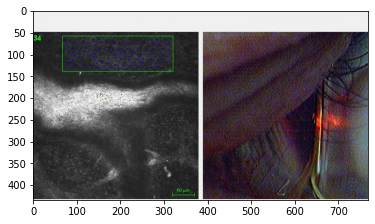

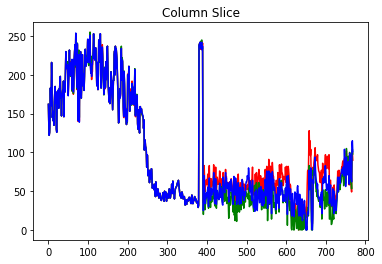

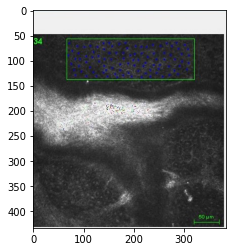

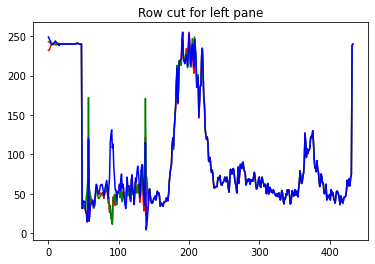

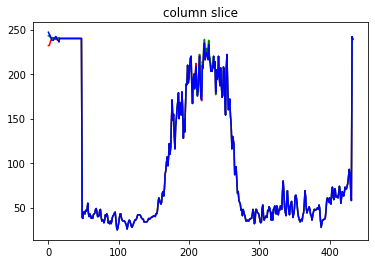

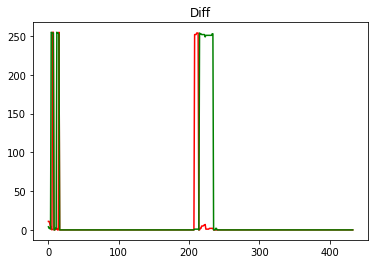

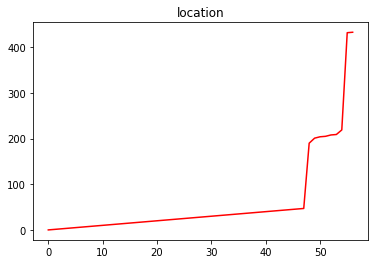

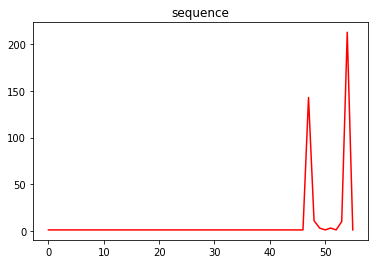

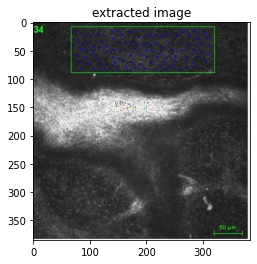

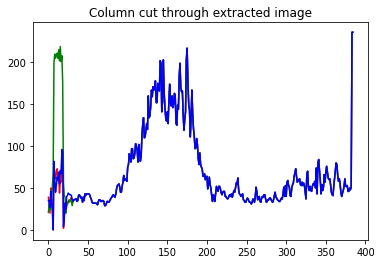

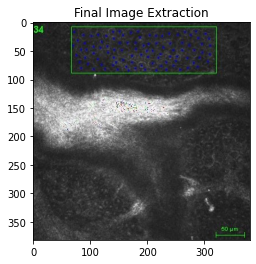

In [66]:
'''
MILD formatted

'''


fname = os.path.join(tp_dir,'Mild','Anonymized','12-2','12-3.count.jpg')
imdata = imageio.imread(os.path.join(fname)) #image_dir,folder,filename))

plt.figure()
plt.imshow(imdata)

n = np.shape(imdata)
nr = n[0]
nc = n[1]

mid_row = int(nr/2)
mid_col = int(nc/2) #middle column will be withing white level sep.
col_slice = imdata[mid_row,:,:]

plt.figure()
plt.plot(col_slice[:,:]) #370:410,:])
plt.title('Column Slice')

left_pane = imdata[:,0:mid_col,:]
plt.figure()
plt.imshow(left_pane)

#
#row
#
newsize = np.shape(left_pane)
newrow = newsize[0]
newcol = newsize[1]

left_column = left_pane[:,int(newcol/2),:]
plt.figure()
plt.plot(left_column)
plt.title('Row cut for left pane')




#
#
#
col_slice = left_pane[:,50,:]

plt.figure()
plt.plot(col_slice)
plt.title('column slice')


a = np.diff(col_slice)
plt.figure()
plt.plot(a)
plt.title('Diff')


upper_bound = 250
lower_bound = 230
location = boundary_check(left_column,lower_bound, upper_bound)
'''
############################################################
# Check for the gray border to correct for any extra windows
# ROW
############################################################
box_count = 0
location = []
counter=0
upper_bound = 250
lower_bound = 230
for count,ii in enumerate(left_column):
    if (   (ii[0] <= upper_bound) & (ii[0] >= lower_bound)  &
        (ii[1] <= upper_bound) & (ii[1] >= lower_bound)  &
        (ii[2] <= upper_bound) & (ii[2] >= lower_bound) ):
        counter = counter + 1 
        location.append(count) #ii)
'''

plt.figure()
plt.plot(location)
plt.title('location')

sequence = np.diff(location)
plt.figure()
plt.plot(sequence)
plt.title('sequence')

#find diff with a gap > 40 pixels
index = np.argwhere(sequence > 50)
print('index is ', index)
start_row = int(index[0] + 2)

sub_image = left_pane[start_row:,:,:]
plt.figure()
plt.imshow(sub_image)
plt.title('extracted image')

plt.figure()
plt.plot(sub_image[:,15,:])
plt.title('Column cut through extracted image')

#subtract last rows with border
#if location values within last 5%, mark those as to be removed
top5 = int(newrow * 0.95)
upper_border = []
for ii in location:
    if (ii >= top5):
        upper_border.append(ii)
print('upper border row values = ',upper_border)

top_border_start = np.min(upper_border)


####################################################################
#COLUMN CORRECTION
#
####################################################################
row_slice = left_pane[mid_row,:,:]

upper_bound = 250
lower_bound = 230
col_location = boundary_check(row_slice,lower_bound, upper_bound)


#subtract last rows with border
#if location values within last 5%, mark those as to be removed
top5 = int(newcol * 0.95)
upper_border = []
for ii in col_location:
    if (ii >= top5):
        upper_border.append(ii)
print('upper border row values = ',upper_border)

col_stop = np.min(upper_border)



######################################################################
#Format Final Image
######################################################################



extracted_image = left_pane[start_row:top_border_start-1,:col_stop,:]

plt.figure()
plt.imshow(extracted_image)
plt.title('Final Image Extraction')

In [63]:
left_column[-5:]
col_location

[44,
 53,
 66,
 67,
 73,
 81,
 93,
 99,
 100,
 104,
 113,
 115,
 119,
 127,
 128,
 136,
 148,
 149,
 167,
 169,
 171,
 184,
 380,
 381,
 382,
 383]